<a href="https://colab.research.google.com/github/kamilahoudek/Projects/blob/master/FINAL%20project_v2/Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor

Dataset k projektu
https://www.kaggle.com/datasets/denizkavi1/brain-tumor?resource=download

1. 1 Meningioma samples (708 files) = tumor that grows from the membranes that surround the brain and spinal cord,
v naprosté většině případů nezhoubný nádor, který vyrůstá z obalu mozku takzvané tvrdé pleny
2. 2 Glioma samples (1426 files) =a growth of cells that starts in the brain or spinal cord,
typ tumoru, jenž vzniká v mozku nebo míše
3. 3 Pituitary tumor samples (930 files) =tumors that occur in the pituitary gland. Most pituitary tumors are benign, approximately 35% are invasive and just 0.1% to 0.2% are carcinomas



In [7]:
############################
# 1. IMPORTS & SETUP
############################
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense,
                                     Dropout, BatchNormalization, GlobalAveragePooling2D)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam


# Step 1: Dataset Exploration
Download the dataset from Kaggle.
Explore the dataset structure (number of classes, sample images, etc.).
Check for data imbalances and preprocessing needs.


In [8]:
import kagglehub

# Download latest version
dataset_path = kagglehub.dataset_download("denizkavi1/brain-tumor")
label_map = {
    '1': 'Meningioma',
    '2': 'Glioma',
    '3': 'Pituitary'
}

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/denizkavi1/brain-tumor/versions/2


## Count Images Per Category

In [9]:
# Quick check: how many images per category?
for category in sorted(os.listdir(dataset_path)):
    category_path = os.path.join(dataset_path, category)
    if os.path.isdir(category_path):
        print(f"{label_map.get(category, category)}: {len(os.listdir(category_path))} images")

Meningioma: 708 images
Glioma: 1426 images
Pituitary: 930 images


## Display Sample Images

In [10]:
def show_sample_images(root_path, num_samples=5):
    """
    Displays a few sample images from each class in grayscale or color as needed.
    """
    categories = sorted(os.listdir(root_path))
    # Filter out files vs. directories if needed:
    categories = [cat for cat in categories if os.path.isdir(os.path.join(root_path, cat))]

    fig, axes = plt.subplots(len(categories), num_samples, figsize=(15, 10))
    for i, category in enumerate(categories):
        category_path = os.path.join(root_path, category)
        images = random.sample(os.listdir(category_path), num_samples)

        for j, img_name in enumerate(images):
            img_path = os.path.join(category_path, img_name)
            # For MobileNetV2, we generally want 3-channel images
            # We'll read it in color:
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (128, 128))  # just for display
            axes[i, j].imshow(img)
            axes[i, j].axis("off")
            if j == 0:
                axes[i, j].set_title(f"{label_map.get(category, category)}")

    plt.tight_layout()
    plt.show()

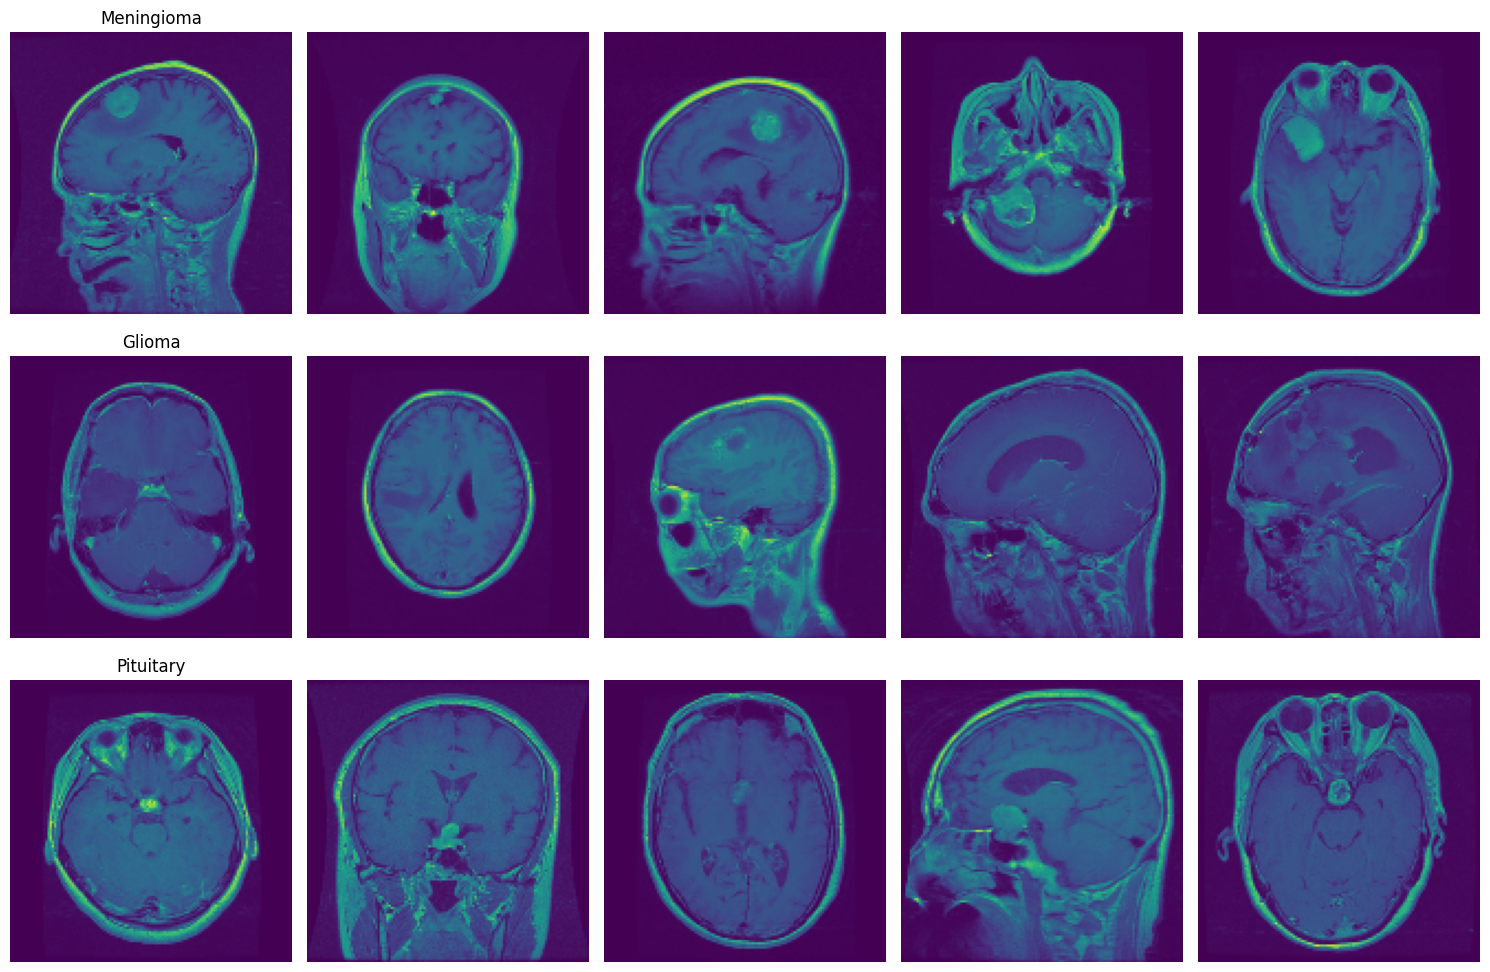

In [11]:
# Display a few sample images
show_sample_images(dataset_path, num_samples=5)

# Step 2: train-val-test split

In [13]:
# We'll create local directories for train/val/test using a typical ratio, e.g., 70/15/15
import shutil
import pathlib

# We'll create a new folder 'brain_tumor_split' to hold the splitted subfolders
base_split_dir = 'brain_tumor_split'
if not os.path.exists(base_split_dir):
    os.makedirs(base_split_dir)

for split in ['train', 'val', 'test']:
    split_dir = os.path.join(base_split_dir, split)
    if not os.path.exists(split_dir):
        os.makedirs(split_dir)
        # also create subdirs for each class
        for cat_key in label_map.keys():
            os.makedirs(os.path.join(split_dir, cat_key))


In [14]:
# Function to split the images
def split_data(original_dir, split_dir, split_ratio=(0.7, 0.15, 0.15)):
    """
    split_ratio: (train, val, test)
    """
    images = os.listdir(original_dir)
    images = [img for img in images if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(images)

    n_total = len(images)
    n_train = int(split_ratio[0] * n_total)
    n_val   = int(split_ratio[1] * n_total)
    n_test  = n_total - n_train - n_val

    train_files = images[:n_train]
    val_files   = images[n_train:n_train+n_val]
    test_files  = images[n_train+n_val:]

    # Copy files into the respective folders
    for f in train_files:
        shutil.copy(os.path.join(original_dir, f),
                    os.path.join(split_dir, 'train', os.path.basename(original_dir), f))
    for f in val_files:
        shutil.copy(os.path.join(original_dir, f),
                    os.path.join(split_dir, 'val', os.path.basename(original_dir), f))
    for f in test_files:
        shutil.copy(os.path.join(original_dir, f),
                    os.path.join(split_dir, 'test', os.path.basename(original_dir), f))

# Apply split to each category folder
for category in label_map.keys():
    cat_folder = os.path.join(dataset_path, category)
    if os.path.isdir(cat_folder):
        split_data(cat_folder, base_split_dir)


# Step 3: Data augmentation

In [15]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_dir = os.path.join(base_split_dir, 'train')
val_dir   = os.path.join(base_split_dir, 'val')
test_dir  = os.path.join(base_split_dir, 'test')

In [16]:
batch_size = 32
img_size = (128, 128)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=img_size,
    color_mode='rgb',  # MobileNet expects 3-channel
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=img_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=img_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 2144 images belonging to 3 classes.
Found 458 images belonging to 3 classes.
Found 462 images belonging to 3 classes.


# Step 4: Model building

In [17]:
# Use MobileNetV2 as a feature extractor
# Setting `include_top=False` means we remove the default classifier to add our own
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze base layers initially

# Add a custom classifier on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(3, activation='softmax')(x)  # 3 classes (Meningioma/Glioma/Pituitary)

model = Model(inputs=base_model.input, outputs=output_layer)

# Compile model
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 64, 64, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 64, 64, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 64, 64, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 64, 64, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 64, 64, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 64, 64, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 64, 64, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 64, 64, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 64, 64, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 65, 65, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 32, 32, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,915,395 (11.12 MB)

 Trainable params: 657,411 (2.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Step 5: Training

In [18]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
ckpt_path = 'best_model.h5'
model_ckpt = ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True)

epochs = 20

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[early_stop, model_ckpt]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 888ms/step - accuracy: 0.6698 - loss: 0.8477

67/67 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.6710 - loss: 0.8445 - val_accuracy: 0.8406 - val_loss: 0.3518
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.8362 - loss: 0.3844 - val_accuracy: 0.7904 - val_loss: 0.4599
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 872ms/step - accuracy: 0.8601 - loss: 0.3310

67/67 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.8602 - loss: 0.3309 - val_accuracy: 0.8886 - val_loss: 0.2889
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 889ms/step - accuracy: 0.8876 - loss: 0.2878

67/67 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.8874 - loss: 0.2881 - val_accuracy: 0.8908 - val_loss: 0.2687
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.9001 - loss: 0.2737 - val_accuracy: 0.8603 - val_loss: 0.2949
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.8845 - loss: 0.2841 - val_accuracy: 0.8624 - val_loss: 0.3226
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 888ms/step - accuracy: 0.9120 - loss: 0.2448

67/67 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.9119 - loss: 0.2450 - val_accuracy: 0.8865 - val_loss: 0.2498
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8863 - loss: 0.2843 - val_accuracy: 0.8755 - val_loss: 0.2936
Epoch 9/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.9143 - loss: 0.2131 - val_accuracy: 0.8777 - val_loss: 0.2737
Epoch 10/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.9078 - loss: 0.2272 - val_accuracy: 0.8581 - val_loss: 0.3488
Epoch 11/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.9113 - loss: 0.2220 - val_accuracy: 0.8581 - val_loss: 0.3062
Epoch 12/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.9056 - loss: 0.2283 - val_accuracy: 0.8886 - val_loss: 0.2520


# Step 6: Evaluation

In [19]:
# Load the best weights
model.load_weights(ckpt_path)

# Evaluate on validation set
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 717ms/step - accuracy: 0.8070 - loss: 0.4051
Validation Loss: 0.2498
Validation Accuracy: 0.8865


In [20]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 730ms/step - accuracy: 0.8140 - loss: 0.4899
Test Loss: 0.3001
Test Accuracy: 0.8874


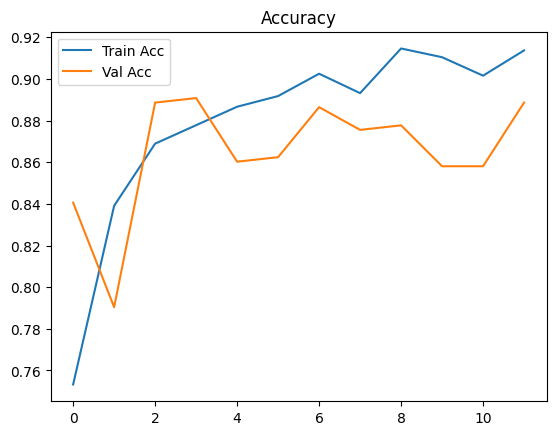

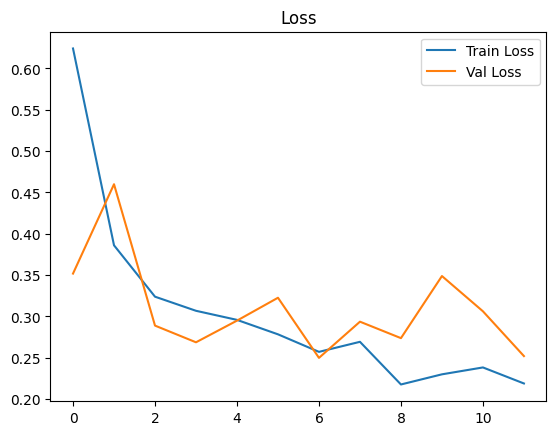

In [21]:
# Plot training curves
plt.figure()
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Step 7: Save/load mode

In [22]:
# Save the final model in Keras format
model.save("brain_tumor_model_final.keras")
print("Model saved as brain_tumor_model_final.keras.")

Model saved as brain_tumor_model_final.keras.


# Zmeny oproti v1

## Key Changes & Rationale


1. Train/Validation/Test Split
Instead of training on all images directly, it’s good practice to create a clear split, ensuring robust evaluation.
2. Data Augmentation
Medical imaging datasets are often small. Augmentation (rotation, shifts, flips) can significantly improve generalization.
3. MobileNetV2
We use include_top=False to remove the default classifier, then freeze its weights, and add our own classification head.
Use preprocess_input specifically for MobileNet.
4. Callbacks
EarlyStopping: Halts training when validation loss stops improving.
ModelCheckpoint: Automatically saves the best weights during training.
5. Evaluation
We explicitly evaluate on both the validation set and a final test set to measure out-of-sample performance.
We also plot training/validation curves.

Feel free to adjust hyperparameters (e.g., IMG_SIZE, batch_size, learning_rate, or data augmentation settings) and experiment with unfreezing deeper MobileNetV2 layers after the initial fine-tuning if you want potentially higher accuracy (at the expense of more training time and risk of overfitting).

This organized approach should give you a solid baseline classification model on the brain tumor dataset—while using best practices for medical imaging tasks with modest data sizes. ​